# Model Interpretation - Pitfalls and Neurscientific Insights

In [25]:
# Imports

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

import shap
shap.initjs()

## Part 1 - Getting the Data and the Model ready

In [ ]:
# Load data
df_cortical = pd.read_csv(Path('../data/cleaned_VBM_GM_Schaefer100x17_mean_aggregation.csv'), index_col=0)
df_subcortical = pd.read_csv(Path('../data/cleaned_VBM_GM_TianxS1x3TxMNI6thgeneration_mean_aggregation.csv'), index_col=0)
df_behav = pd.read_csv(Path('../data/cleaned_IXI_behavioural.csv'), index_col=0)

df_brain = df_cortical.join(df_subcortical, how="inner")
print(f"Brain data shape: {df_brain.shape}")

df_data = df_behav.join(df_brain, how="inner")
print(f"Final data shape: {df_data.shape}")

Final data shape: (535, 122)


In [29]:
# Nested GridSearchCV inclusing standard scaling of features (only train-test split, not outer CV) (partial recap)
columns_GMV = df_cortical.columns.to_list() + df_subcortical.columns.to_list()

# Split before any further computations to avoid leakage
train_data, test_data = train_test_split(df_data, test_size=0.2, random_state=42)

# Ridge model inside a pipeline
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Grid search on alpha (internal CV within training set)
param_grid = {'ridge__alpha': [0.001, 0.1, 0.5, 1.0, 10.0]}
grid = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')
grid.fit(train_data[columns_GMV], train_data['HEIGHT'])

best_alpha = grid.best_params_['ridge__alpha']
print(f"Best alpha from inner CV: {best_alpha}")

y_pred = grid.predict(test_data[columns_GMV])
y_true = test_data['HEIGHT']
R2_test = r2_score(y_true, y_pred)
r_test = np.corrcoef(y_true, y_pred)[0, 1]
print(f"Test R² = {R2_test:.3f}")
print(f"Test Pearson r = {r_test:.3f}")

# Check for overfitting - Compare train and test performance
# Predict on training data
y_train_pred = grid.predict(train_data[columns_GMV])
y_train_true = train_data['HEIGHT']
R2_train = r2_score(y_train_true, y_train_pred)
r_train = np.corrcoef(y_train_true, y_train_pred)[0, 1]
print(f"Train R² = {R2_train:.3f}")
print(f"Train Pearson r = {r_train:.3f}")

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/pipeline.py", line 476, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py", line 1242, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1273, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1059, in check_array
    _assert_all_finite(
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/utils/validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/fraimondo/miniforge3/envs/julearn/lib/python3.11/site-packages/sklearn/utils/validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


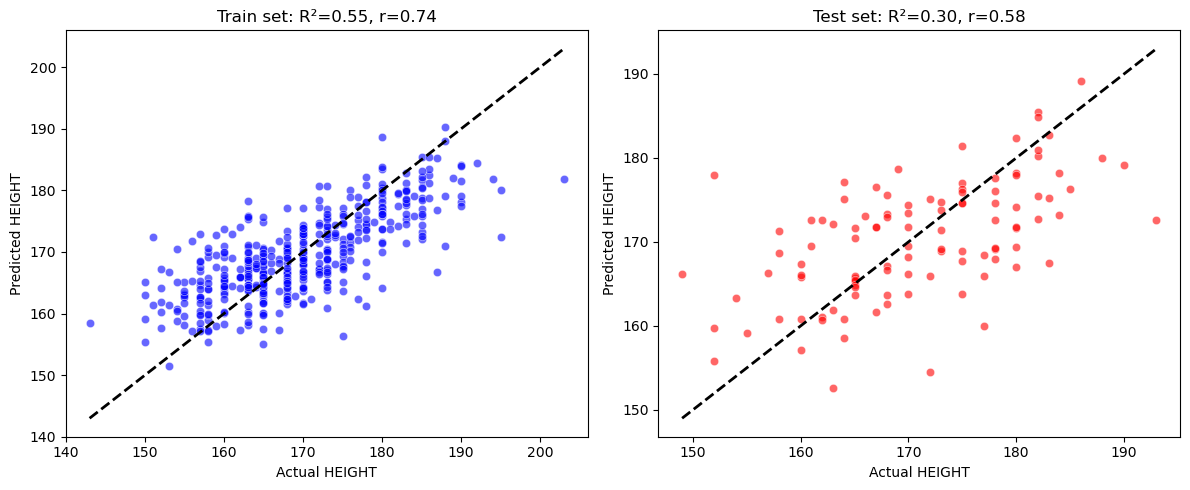

In [ ]:
# Visualize true vs. predicted on test and training data
# Prepare figure
plt.figure(figsize=(12,5))

# Train set plot
plt.subplot(1,2,1)
sns.scatterplot(x=y_train_true, y=y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'k--', lw=2)
plt.xlabel("Actual HEIGHT")
plt.ylabel("Predicted HEIGHT")
plt.title(f"Train set: R²={R2_train:.2f}, r={r_train:.2f}")

# Test set plot
plt.subplot(1,2,2)
sns.scatterplot(x=y_true, y=y_pred, color='red', alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel("Actual HEIGHT")
plt.ylabel("Predicted HEIGHT")
plt.title(f"Test set: R²={R2_test:.2f}, r={r_test:.2f}")

plt.tight_layout()
plt.show()


**Questions**: 
1. Why did we compute performance measures for train and test set
2. What do you take from this output (the comparison of train and test performance)?
3. What simplification in the pipeline did we make that should usually be done differntly? (hint: how did we split the data?)

## Part 2 - Model Weights as global feature importance

In [ ]:
# extract coefficients from the trained pipeline
ridge = grid.best_estimator_.named_steps["ridge"]
scaler = grid.best_estimator_.named_steps["scaler"]

# scale coefficients back to original units (because we standardized the features before fitting the model)
coef_scaled = ridge.coef_ / scaler.scale_  # scaler.scale_ is the per-feature standard deviation used for scaling
coef_series = pd.Series(coef_scaled, index=columns_GMV)

# Get top n features by absolute weight
top_n = 15
top_features = coef_series.abs().sort_values(ascending=False).head(top_n).index
print(f"Top {top_n} features (absolute weights): \n")
coef_series.abs().sort_values(ascending=False).head(top_n)


Top 15 features (absolute weights): 



LH_VisPeri_ExStrInf_1      41.683342
RH_DorsAttnB_PostC_2       38.497473
LH_SalVentAttnB_PFCmp_1    38.495961
RH_SalVentAttnB_PFCmp_1    35.027841
LH_DefaultC_PHC_1          32.741823
RH_SalVentAttnA_Ins_1      32.396158
RH_DefaultB_PFCv_2         31.402465
LH_DorsAttnB_FEF_1         31.392718
RH_DefaultA_IPL_1          30.248564
NAc-lh                     30.153437
LH_SomMotA_2               29.863050
CAU-lh                     29.536885
RH_LimbicA_TempPole_1      28.270112
LH_DefaultB_PFCd_1         27.188718
RH_DorsAttnA_TempOcc_1     25.303004
dtype: float64

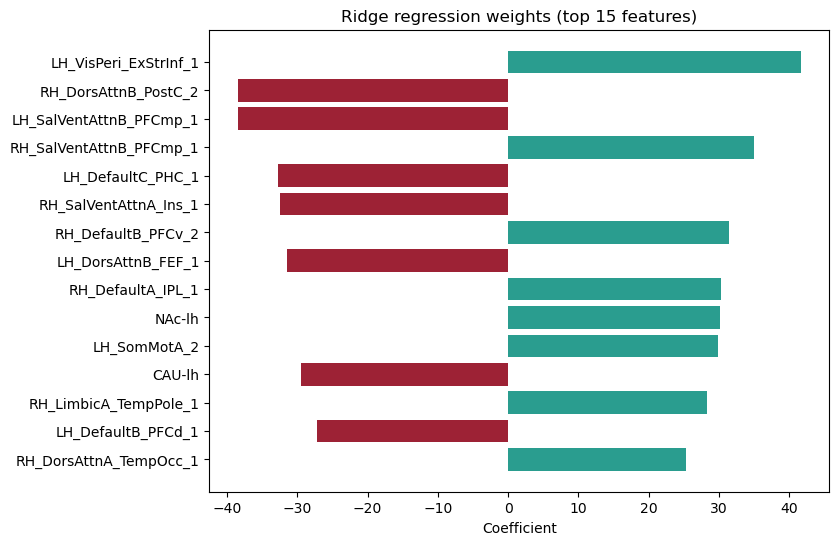

In [ ]:
# Visualize the top weights
# Create a list of colors: blue for positive, red/purple for negative
coef_vals = coef_series[top_features]  # ensure ordering matches top_features
colors = ["#2a9d8f" if v >= 0 else "#9d2235" for v in coef_vals]

plt.figure(figsize=(8,6))
plt.barh(top_features, coef_vals, color=colors)
plt.xlabel("Coefficient")
plt.title("Ridge regression weights (top 15 features)")
plt.gca().invert_yaxis()  # optional: largest coefficient on top
plt.show()



## Part 3 - Feature Multicollinearities

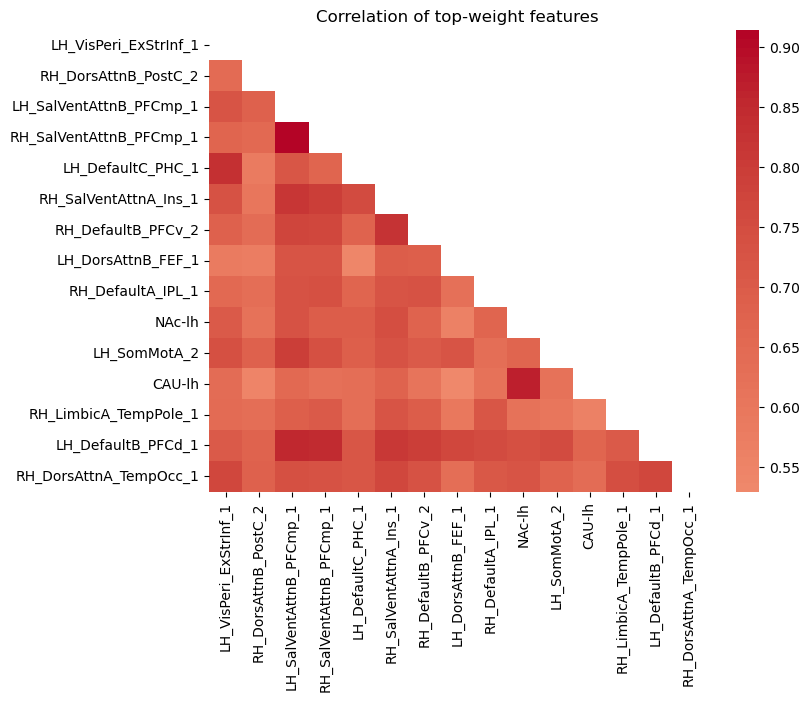

In [ ]:
# absolute correlation heatmap among features
corr = train_data[columns_GMV][top_features].corr().abs()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# visualize
plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0)
plt.title("Correlation of top-weight features")
plt.show()

Features selected for visualization: LH_VisCent_ExStr_1, LH_SomMotB_Aud_1
Correlation between LH_VisCent_ExStr_1 and LH_SomMotB_Aud_1: r = 0.71
Model coefficients: LH_VisCent_ExStr_1: -7.1339, LH_SomMotB_Aud_1: 2.9229


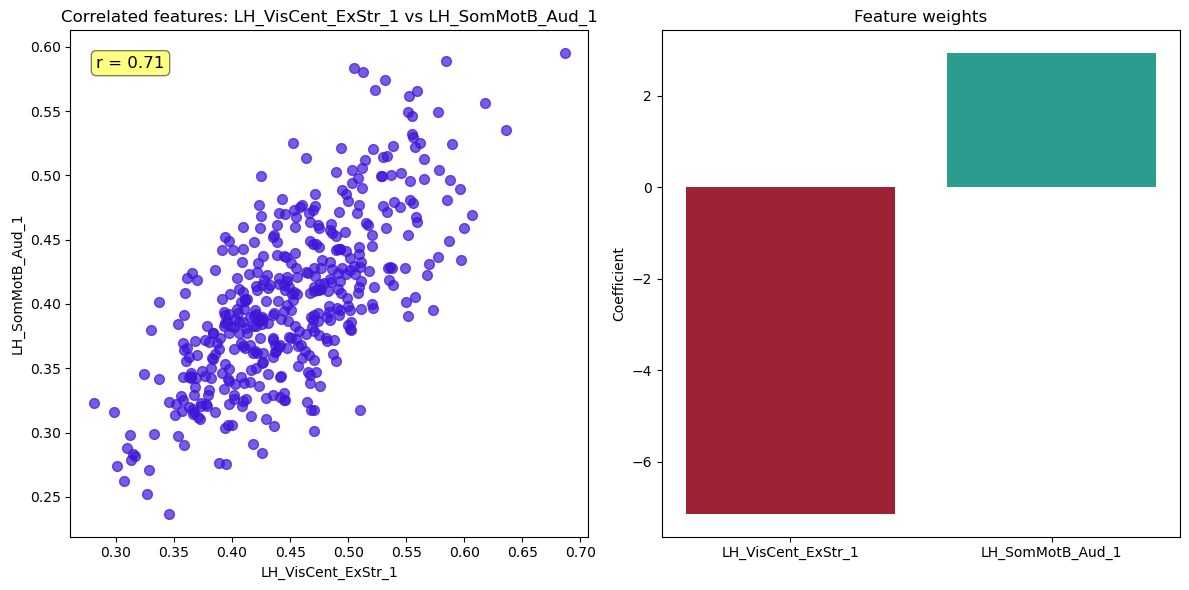

In [ ]:
feature_pair_pick = (
    6  # index of the feature pair to visualize - change this to see different pairs
)

# Find a pair of correlated features
corr_matrix = pd.DataFrame(df_brain).corr()
high_corr_pairs = [
    (f1, f2)
    for f1 in columns_GMV
    for f2 in columns_GMV
    if f1 != f2 and corr_matrix.loc[f1, f2] > 0.7
]

# Pick one pair for visualization
f1, f2 = high_corr_pairs[feature_pair_pick]
print(f"Features selected for visualization: {f1}, {f2}")
print(f"Correlation between {f1} and {f2}: r = {corr_matrix.loc[f1,f2]:.2f}")
print(f"Model coefficients: {f1}: {coef_series[f1]:.4f}, {f2}: {coef_series[f2]:.4f}")

# Get the coefficients of the two features
coef_vals_pair = coef_series.iloc[[columns_GMV.index(f1), columns_GMV.index(f2)]]
features_pair = [f1, f2]

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: scatter plot of feature values
axes[0].scatter(
    train_data[f1],
    train_data[f2],
    color="#3f15d8",
    s=50,
    alpha=0.7,
)
axes[0].set_xlabel(f1)
axes[0].set_ylabel(f2)
axes[0].set_title(f"Correlated features: {f1} vs {f2}")
axes[0].annotate(
    f"r = {corr_matrix.loc[f1,f2]:.2f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),
)

# Right: bar plot of the feature weights
axes[1].bar(
    features_pair,
    coef_vals_pair,
    color=["#2a9d8f" if v >= 0 else "#9d2235" for v in coef_vals_pair],
)
axes[1].set_ylabel("Coefficient")
axes[1].set_title("Feature weights")

plt.tight_layout()
plt.show()

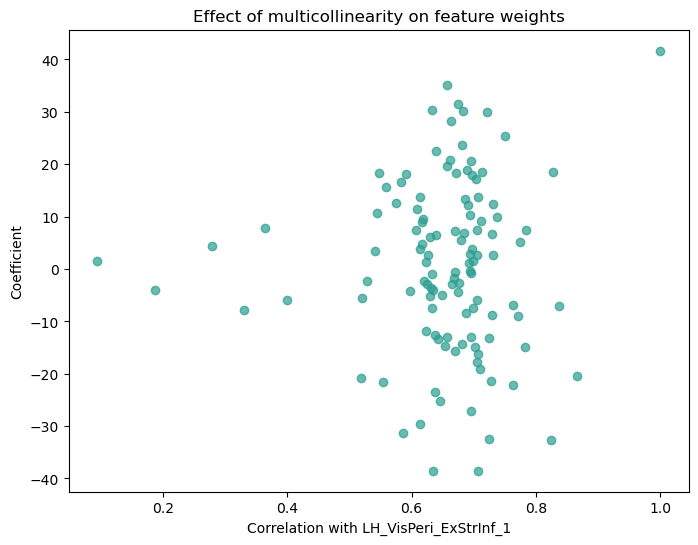

In [ ]:
# Relationship between feature weights and their correlation with the top-weight feature

# select the top-weight feature
top_feature = top_features[0]

# Absolute correlation of all features with the top-weight feature
feature_corr_with_top = corr_matrix[top_feature].abs().loc[columns_GMV]

plt.figure(figsize=(8,6))
plt.scatter(feature_corr_with_top, coef_series[columns_GMV], color="#2a9d8f", alpha=0.7)
plt.xlabel(f"Correlation with {top_feature}")
plt.ylabel("Coefficient")
plt.title("Effect of multicollinearity on feature weights")
plt.show()



## Part 4 - SHAP values (global and local explanations)

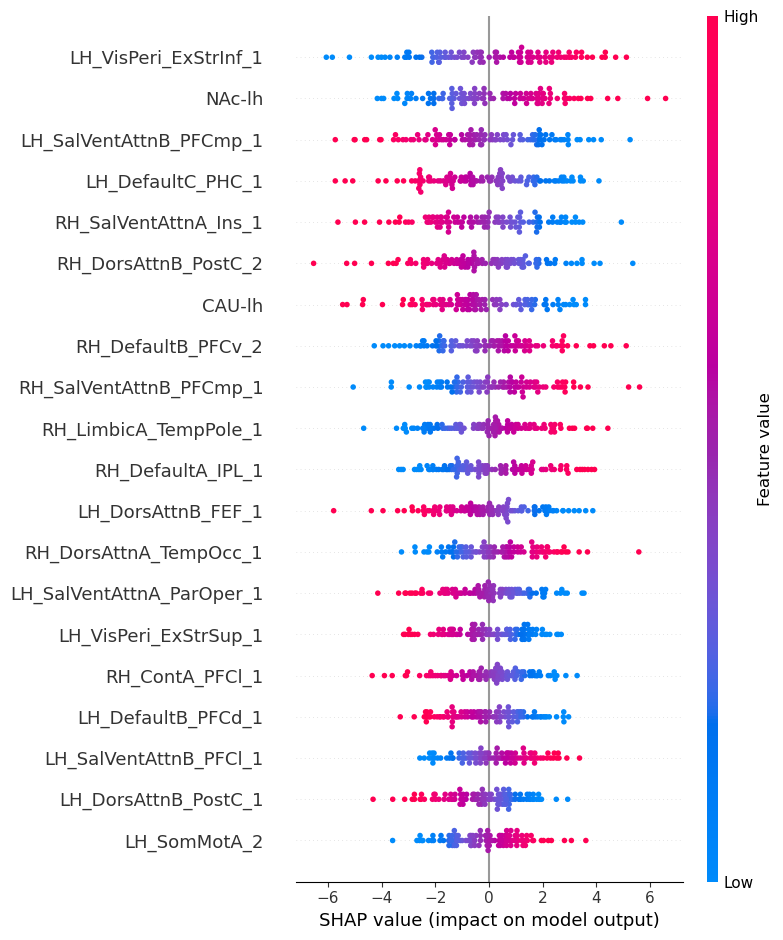

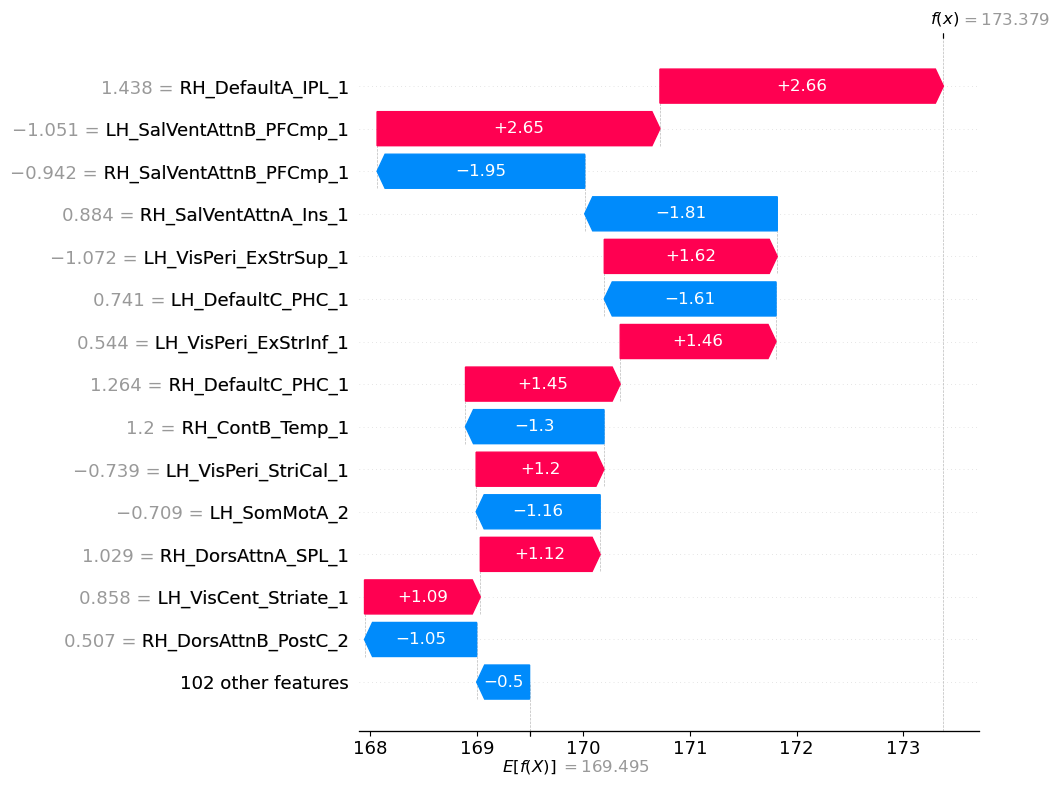

In [ ]:
# define the explainer
explainer = shap.Explainer(
    grid.best_estimator_.named_steps["ridge"],
    scaler.transform(train_data[columns_GMV]),
    feature_names=columns_GMV,
)

test_features_scaled = scaler.transform(test_data[columns_GMV])

shap_values = explainer(test_features_scaled)

# Global summary plot
shap.summary_plot(
    shap_values,
    features=test_features_scaled,
    feature_names=columns_GMV,
)

# Local explanation for one subject
i = 0
shap.plots.waterfall(shap_values[i], max_display=15)

Correlation between absolute SHAP values and absolute coefficients: r = 0.98


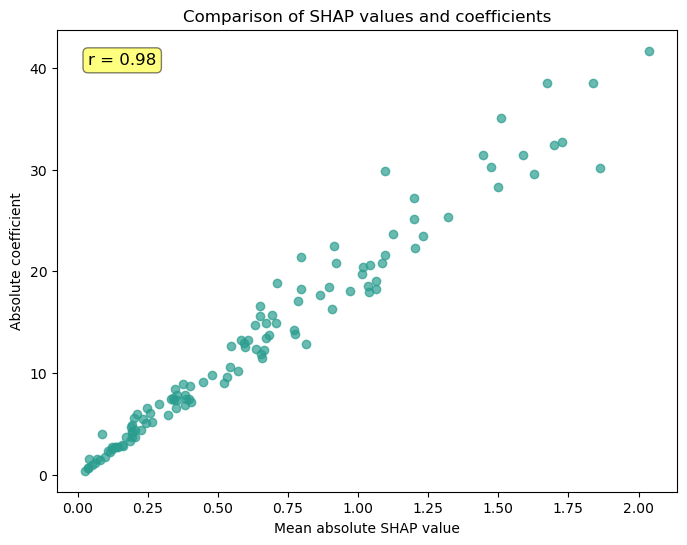

In [ ]:
# Consistency of results between coefficients and SHAP values
# Correlation between absolute SHAP values and absolute coefficients
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_coef_corr = np.corrcoef(mean_abs_shap, coef_series.abs().values)[0,1]
print(f"Correlation between absolute SHAP values and absolute coefficients: r = {shap_coef_corr:.2f}")

# visualize 
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(mean_abs_shap, np.abs(coef_series.values), color="#2a9d8f", alpha=0.7)
ax.set_xlabel("Mean absolute SHAP value")
ax.set_ylabel("Absolute coefficient")
ax.set_title("Comparison of SHAP values and coefficients")
ax.annotate(
    f"r = {shap_coef_corr:.2f}",
    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
    horizontalalignment='left', verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5))
plt.show()

**Information**:
In this case SHAP values and the ridge coefficient are highly correlating. Shap can still be useful for models which do not provide the direct option for interpretation. However, SHAP values cannot account for feature multicollinearities as SHAP assumes feature independence.

## Part 5 - SHAP values for a non-linear model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # not strictly needed for RF, but keeps things consistent
    ("rf", RandomForestRegressor(random_state=42))
])

# Define grid of hyperparameters
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [3, 5, 7],
    "rf__min_samples_split": [5, 10],
    "rf__min_samples_leaf": [2, 5],
    "rf__max_features": [0.2, "sqrt"]
}

# Grid search with 5-fold CV
grid_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring="r2", n_jobs=1)
grid_rf.fit(train_data[columns_GMV], train_data['HEIGHT'])
print(f"Best hyperparameters: {grid_rf.best_params_}")

# Predict on test set
rf_best = grid_rf.best_estimator_
rf_pred = rf_best.predict(test_data[columns_GMV])
print(f"RandomForest Test R² = {r2_score(test_data['HEIGHT'], rf_pred):.3f}")
print(f"RandomForest Test r = {np.corrcoef(test_data['HEIGHT'], rf_pred)[0, 1]:.3f}")

# Prediction on training set
rf_pred_train = rf_best.predict(train_data[columns_GMV])
print(f"RandomForest Train R² = {r2_score(train_data['HEIGHT'], rf_pred_train):.3f}")
print(f"RandomForest Train r = {np.corrcoef(train_data['HEIGHT'], rf_pred_train)[0, 1]:.3f}")


Best hyperparameters: {'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
RandomForest Test R² = 0.299
RandomForest Test r = 0.551
RandomForest Train R² = 0.678
RandomForest Train r = 0.865


**Question**: Does it make sense with these performance results to do the shap analysis? If yes, why? If not, why?

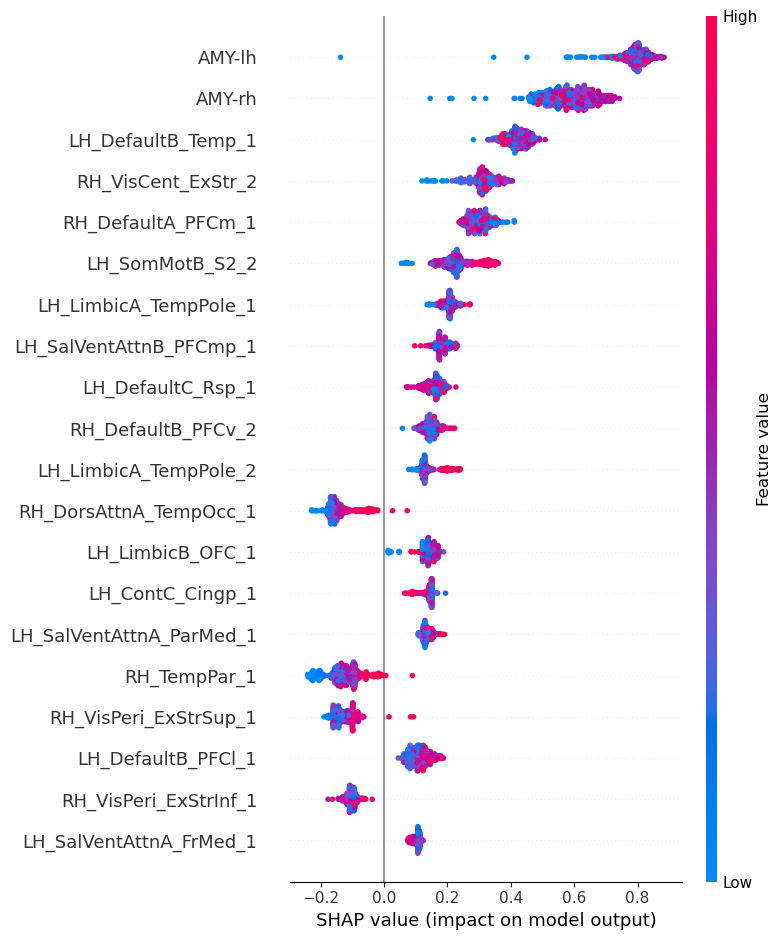

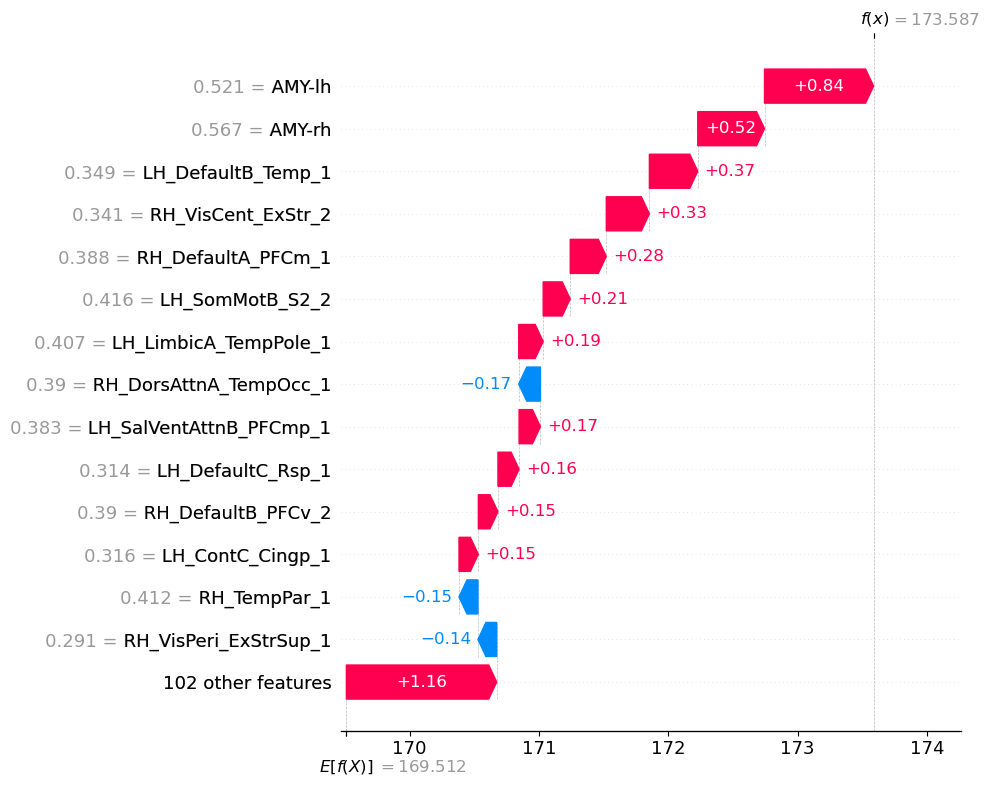

In [ ]:
# SHAP TreeExplainer
rf_explainer = shap.TreeExplainer(rf_best.named_steps["rf"])
rf_shap_values = rf_explainer(train_data[columns_GMV])

# Global summary for RF
shap.summary_plot(rf_shap_values, features=train_data[columns_GMV], feature_names=columns_GMV)

# Local explanation for first test sample (example)
i = 0
shap.plots.waterfall(rf_shap_values[i], max_display=15)

## Part 6 - How to overcome multicollinearities - Owen values with feature clustering

In [ ]:
from shap.utils import hclust

# Extract scaled training and test data
scaler = grid.best_estimator_.named_steps["scaler"]
ridge_model = grid.best_estimator_.named_steps["ridge"]

X_train_scaled = scaler.transform(train_data[columns_GMV])
X_test_scaled = scaler.transform(test_data[columns_GMV])

# Cluster features based on correlation in training data
feature_order = hclust(
        X_train_scaled, train_data['HEIGHT'],
        metric="xgboost_distances_r2",
        linkage="average")  # use XGBoost clustering evaluating shared information with target

# Build partition masker for Owen values
# The Partition masker uses hierarchical clustering to define coalitions
bg_masker = shap.maskers.Partition(
    X_train_scaled, max_samples=100, clustering=feature_order)

# Build Permutation explainer for Owen values
# Note: Ridge model needs a predict function
owen_explainer = shap.Explainer(ridge_model.predict, masker=bg_masker)

# Calculate Owen values on test data
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_GMV)
owen_values = owen_explainer(X_test_scaled_df, max_evals=5000)

# # Global Owen summary plot
# shap.summary_plot(
#     owen_values,
#     features=X_test_scaled,
#     feature_names=columns_GMV,
# )

# # Local Owen explanation for a single test sample
# i = 0  # example test sample
# shap.plots.waterfall(owen_values[i], max_display=15)



13457it [01:44, 115.57it/s]                           
PermutationExplainer explainer: 108it [00:12,  2.30it/s]                         


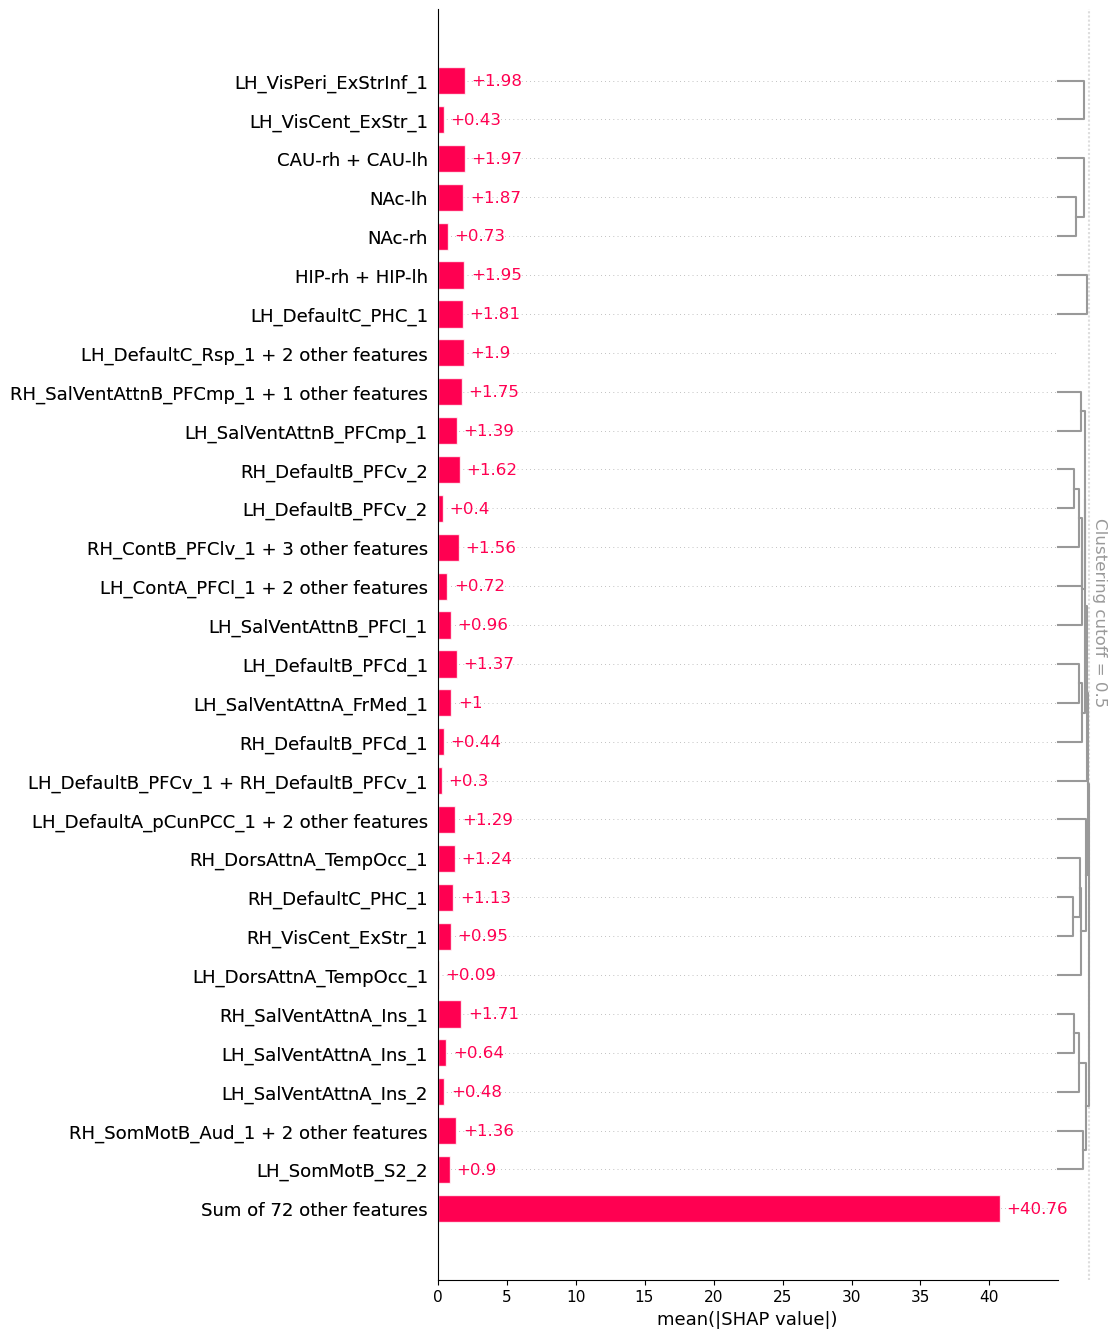

In [ ]:
# show mean absolute Owen values with clustering and custom set cutoff
shap.plots.bar(
    owen_values, max_display=30, clustering_cutoff=0.5, # default: 0.5
)

**Question**:
1. What do you take from this plot?
2. How does this compare to the Ridge Feature Coefficients we computed above?